<a href="https://colab.research.google.com/github/VijethAmin/CRM-project/blob/main/project_TIME_SERIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import yfinance as yf
import pandas as pd

# 1. Download data
ticker = yf.Ticker("AAPL")
df = ticker.history(start="2020-01-01", end="2025-07-24", interval="1d")

# 2. Keep only the required columns
df = df.loc[:, ["Open", "High", "Low", "Close", "Volume"]].reset_index()

# 3. Save to CSV
df.to_csv("AAPL_2020_2025_daily.csv", index=False)

# 4. Preview first 5 rows
print(df.head())


                       Date       Open       High        Low      Close  \
0 2020-01-02 00:00:00-05:00  71.627084  72.681281  71.373211  72.620834   
1 2020-01-03 00:00:00-05:00  71.847110  72.676439  71.689950  71.914810   
2 2020-01-06 00:00:00-05:00  71.034709  72.526533  70.783248  72.487846   
3 2020-01-07 00:00:00-05:00  72.497545  72.753839  71.926930  72.146957   
4 2020-01-08 00:00:00-05:00  71.849548  73.609760  71.849548  73.307526   

      Volume  
0  135480400  
1  146322800  
2  118387200  
3  108872000  
4  132079200  


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv("AAPL_2020_2025_daily.csv")



# Select only needed columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Check for nulls
print(df.isnull().sum())

# Fill or drop missing values
df = df.dropna()


Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


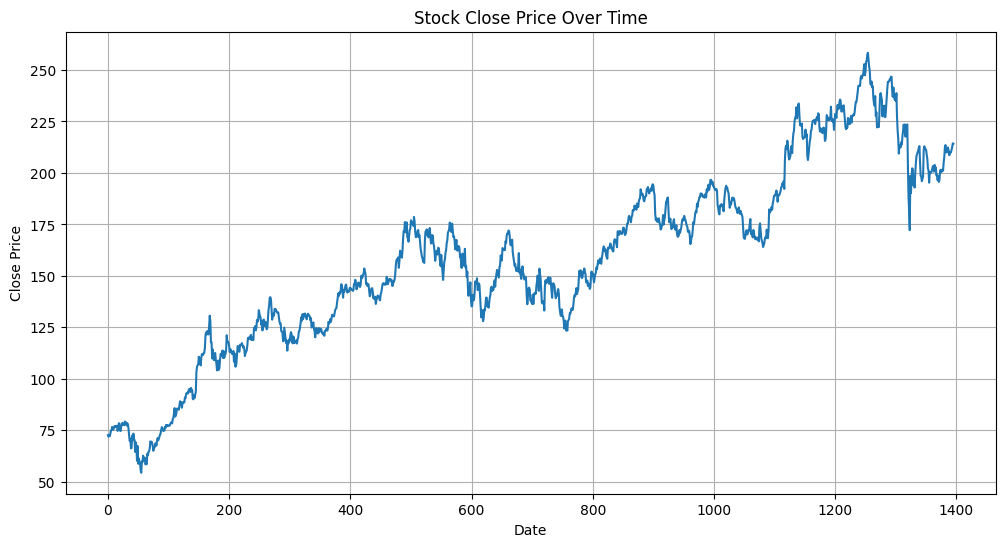

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


Metric	Value
ADF Statistic	-1.67

p-value	0.444 ❌
Critical Value (5%)	-2.86


Conclusion	Not Stationary ❌

Why?
Your ADF Statistic (-1.67) is greater than the 5% critical value (-2.86)

The p-value (0.444) is greater than 0.05

📌 So the series is not stationary. Time series models like ARIMA and SARIMA require stationarity to perform well.

Next Step: Make Series Stationary
We will now apply differencing (subtract previous value from current) to remove trend and make the data stationary.

In [40]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic: -1.6745025385966075
p-value: 0.444295088182308
Critical Value (1%): -3.435046325299633
Critical Value (5%): -2.8636140901080456
Critical Value (10%): -2.567874239154173


❌ Interpretation:
Since the ADF Statistic (-1.6745) is greater than all critical values (in absolute terms), and the p-value (0.4443) is much greater than 0.05, we fail to reject the null hypothesis.

🔴 This means the time series is non-stationary.

In [41]:
# Apply first differencing
df['Close_diff'] = df['Close'].diff()
df_diff = df['Close_diff'].dropna()

# Re-check stationarity
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(df_diff)
print(f"ADF Statistic (Differenced): {result_diff[0]}")
print(f"p-value (Differenced): {result_diff[1]}")
for key, value in result_diff[4].items():
    print(f'Critical Value ({key}): {value}')


ADF Statistic (Differenced): -22.19251319094571
p-value (Differenced): 0.0
Critical Value (1%): -3.435056465447021
Critical Value (5%): -2.8636185648927617
Critical Value (10%): -2.567876622097536


📈 ADF Test After Differencing — Interpretation:
ADF Statistic = -22.19

p-value = 0.0

Since the ADF statistic < all critical values and p-value < 0.05,
➤ We reject the null hypothesis
➤ ✅ The series has no unit root, i.e., it is stationary

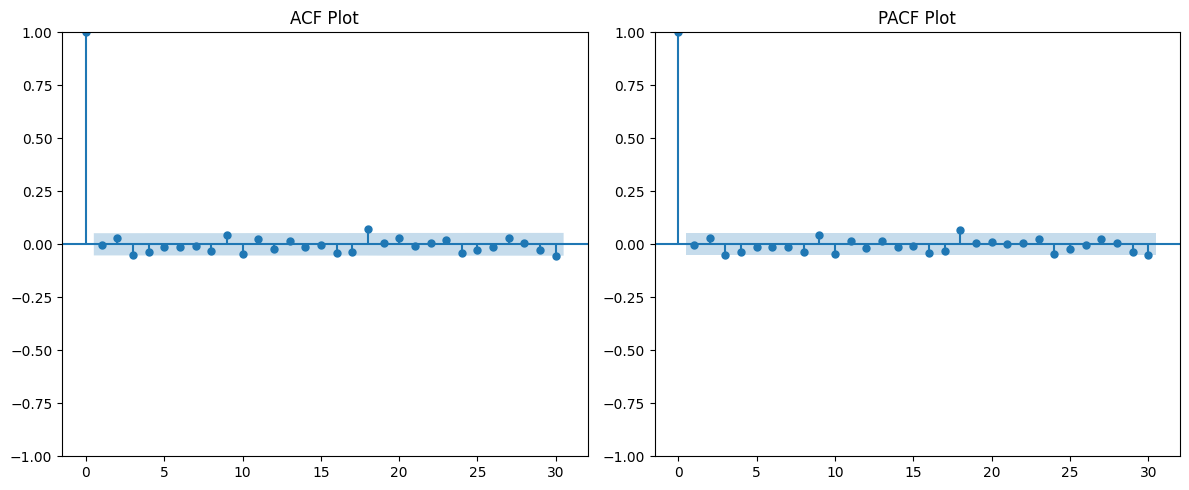

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(df_diff, ax=plt.gca(), lags=30)
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(df_diff, ax=plt.gca(), lags=30)
plt.title('PACF Plot')
plt.tight_layout()
plt.show()


🔍 Interpretation:
ACF (Autocorrelation Function) Plot:
Sharp drop after lag 1 and remains within confidence bounds.

Suggests a Moving Average (MA) component of q = 1.

PACF (Partial Autocorrelation Function) Plot:
Sharp drop after lag 1 and the rest fall within confidence bounds.

Suggests an AutoRegressive (AR) component of p = 1.


We’ll now proceed to fit the ARIMA model with (1,1,1) and forecast the future values.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1116
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2641.132
Date:                Thu, 24 Jul 2025   AIC                           5288.264
Time:                        14:46:25   BIC                           5303.314
Sample:                             0   HQIC                          5293.954
                               - 1116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4823      0.567      0.851      0.395      -0.629       1.594
ma.L1         -0.5133      0.559     -0.918      0.358      -1.609       0.582
sigma2         6.6831      0.210     31.793      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


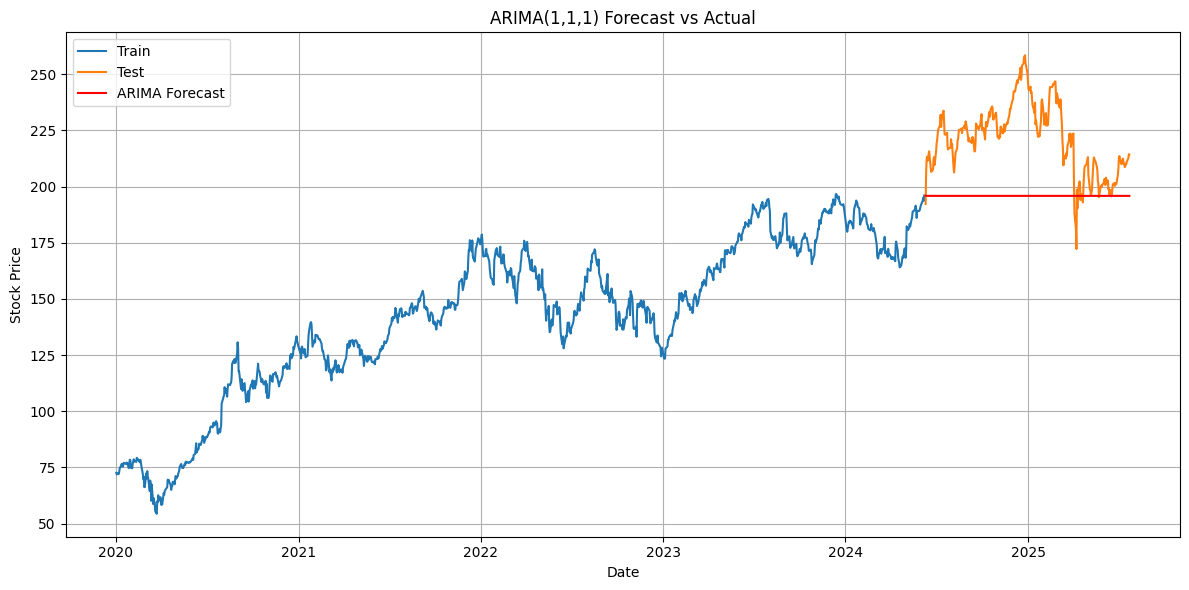


📊 Evaluation Metrics:
MAE  = 25.9283
MSE  = 883.5432
RMSE = 29.7245


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load your stock dataset (already preprocessed and differenced)
# The dataframe 'df' is already loaded and has 'Date' as index from previous steps.
# So, we don't need to load it again and set the index.
# df = pd.read_csv("AAPL_2020_2025_daily.csv", parse_dates=["Date"], index_col="Date")
# df = df.sort_index()

# These lines are redundant as Date is already the index
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)


# Use only 'Close' prices for ARIMA
close_prices = df['Close']

# Split into train and test
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

# Fit ARIMA(1,1,1)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecast for the test period using integer indices
start_index = len(train)
end_index = len(close_prices) - 1 # The last index of the original data
forecast = model_fit.predict(start=start_index, end=end_index)

# Ensure the forecast has the same index as the test set for plotting and evaluation
forecast.index = test.index


# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red') # Plot forecast against its own index
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMA(1,1,1) Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print(f"\n📊 Evaluation Metrics:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")

In [52]:
print(df.index)


Index([2020-01-02 00:00:00-05:00, 2020-01-03 00:00:00-05:00,
       2020-01-06 00:00:00-05:00, 2020-01-07 00:00:00-05:00,
       2020-01-08 00:00:00-05:00, 2020-01-09 00:00:00-05:00,
       2020-01-10 00:00:00-05:00, 2020-01-13 00:00:00-05:00,
       2020-01-14 00:00:00-05:00, 2020-01-15 00:00:00-05:00,
       ...
       2025-07-10 00:00:00-04:00, 2025-07-11 00:00:00-04:00,
       2025-07-14 00:00:00-04:00, 2025-07-15 00:00:00-04:00,
       2025-07-16 00:00:00-04:00, 2025-07-17 00:00:00-04:00,
       2025-07-18 00:00:00-04:00, 2025-07-21 00:00:00-04:00,
       2025-07-22 00:00:00-04:00, 2025-07-23 00:00:00-04:00],
      dtype='object', name='Date', length=1396)


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


In [54]:
# Fit SARIMA model
sarima_model = SARIMAX(df['Close'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1396
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3464.276
Date:                            Thu, 24 Jul 2025   AIC                           6938.552
Time:                                    14:20:23   BIC                           6964.662
Sample:                                         0   HQIC                          6948.323
                                           - 1396                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0323      1.601      0.020      0.984      -3.105       3.170
ma.L1         -0.0338      1.602   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


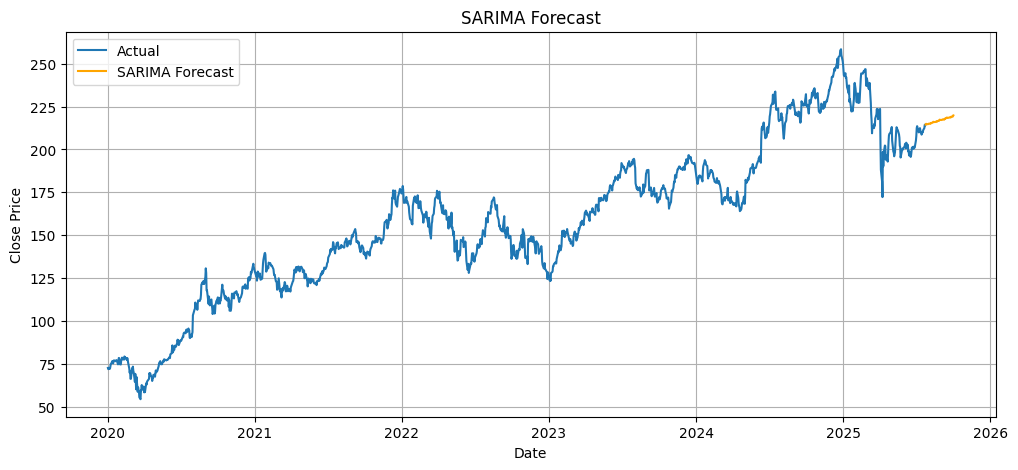

In [55]:
# Forecast for the last 50 steps
n_steps = 50
sarima_forecast = sarima_result.forecast(steps=n_steps)

# Plot forecast
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'], label='Actual')
plt.plot(pd.date_range(df.index[-1], periods=n_steps+1, freq='B')[1:], sarima_forecast, label='SARIMA Forecast', color='orange')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
# In-sample prediction (backtesting)
sarima_pred = sarima_result.predict(start=len(df)-100, end=len(df)-1)

# Actual values
actual_values = df['Close'][-100:]

# Metrics
mae = mean_absolute_error(actual_values, sarima_pred)
mse = mean_squared_error(actual_values, sarima_pred)
rmse = np.sqrt(mse)

print(f" SARIMA Evaluation Metrics:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")


 SARIMA Evaluation Metrics:
MAE  = 3.3189
MSE  = 27.6871
RMSE = 5.2619


In [81]:
from prophet import Prophet
import pandas as pd

# Reset index to bring 'Date' back as a column
df_prophet = df.reset_index()

# Convert the timezone-aware 'Date' column string to timezone-naive by removing the offset
df_prophet['Date'] = df_prophet['Date'].astype(str).str.replace(r'[-\+]\d{2}:\d{2}', '', regex=True)

# Convert the cleaned string column to datetime objects (should be timezone-naive now)
df_prophet['Date'] = pd.to_datetime(df_prophet['Date'])

# Rename columns as required by Prophet
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'})

# Check the first few rows
display(df_prophet.head())

,ds,Open,High,Low,y,Volume
0,2020-01-02,71.627084,72.681281,71.373211,72.620834,135480400
1,2020-01-03,71.847110,72.676439,71.689950,71.914810,146322800
2,2020-01-06,71.034709,72.526533,70.783248,72.487846,118387200
3,2020-01-07,72.497545,72.753839,71.926930,72.146957,108872000
4,2020-01-08,71.849548,73.609760,71.849548,73.307526,132079200


from matplotlib import pyplot as plt
_df_0['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Low', y='y', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='y', y='Volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['Open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('Open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['High']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('High')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['Low']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('Low')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ds']
  ys = series['y']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('y')

from matplotlib import pyplot as plt
_df_12['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

In [83]:
# Initialize the model
model_prophet = Prophet(daily_seasonality=True)

# Fit the model to data
model_prophet.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4qnro4wu/19eow04_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4qnro4wu/mcipry3w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45789', 'data', 'file=/tmp/tmp4qnro4wu/19eow04_.json', 'init=/tmp/tmp4qnro4wu/mcipry3w.json', 'output', 'file=/tmp/tmp4qnro4wu/prophet_modelx5buvrcy/prophet_model-20250724143034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Make Future DataFrame
We’ll create a future dataframe for the next n days (e.g., 30 days):

In [84]:
# Forecast 30 days into the future
future = model_prophet.make_future_dataframe(periods=30)

# View the future dataframe
future.tail()


,ds
1421,2025-08-18
1422,2025-08-19
1423,2025-08-20
1424,2025-08-21
1425,2025-08-22


In [85]:
# Make predictions
forecast = model_prophet.predict(future)

# View forecast results
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1421,2025-08-18,230.826375,221.524064,240.989808
1422,2025-08-19,231.188973,220.932947,240.763084
1423,2025-08-20,231.497079,221.479031,241.316142
1424,2025-08-21,231.725483,222.186949,241.076301
1425,2025-08-22,232.110473,222.061988,242.615548


Now let's visualize and evaluate the forecast.

,ds,yhat,yhat_lower,yhat_upper
1756,2026-07-19,230.558131,155.385809,306.056300
1757,2026-07-20,229.508204,154.469443,302.904123
1758,2026-07-21,229.647200,155.996609,303.242474
1759,2026-07-22,229.731455,155.235928,306.566396
1760,2026-07-23,229.744952,156.415252,306.127218


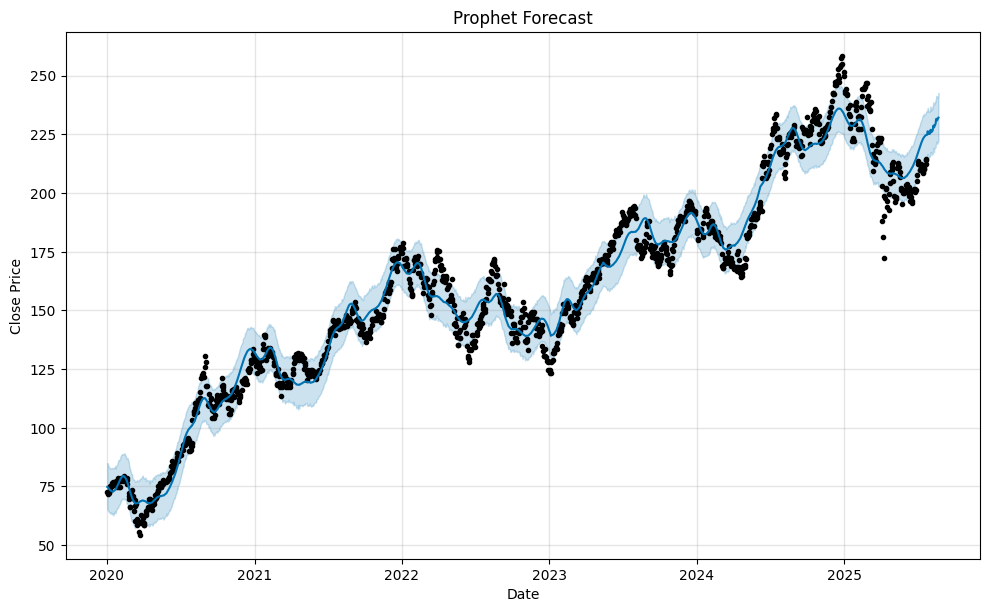

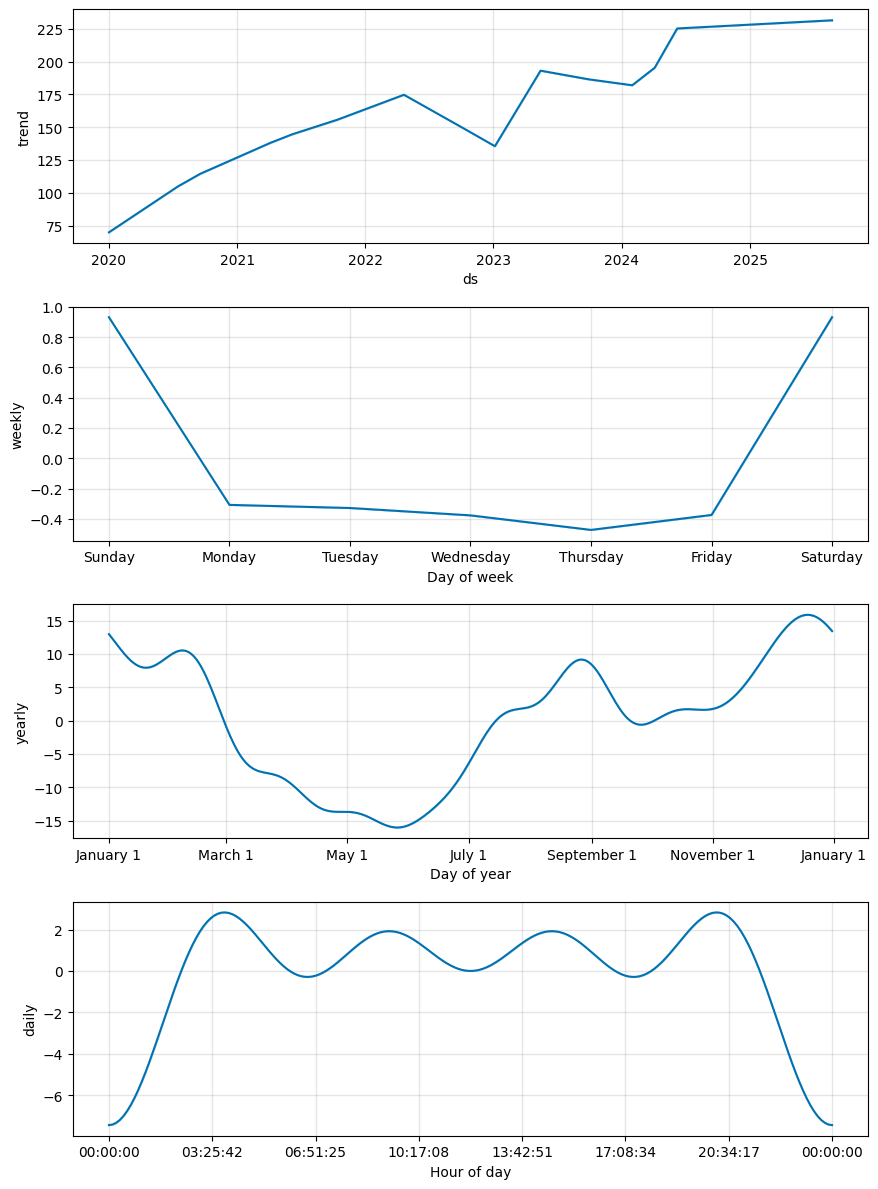

In [88]:
# Create a DataFrame with future dates for forecasting
future = model_prophet.make_future_dataframe(periods=365) # Forecast for the next year (adjust periods as needed)

# Make predictions
forecast_prophet = model_prophet.predict(future)

# Display the forecast
display(forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

model_prophet.plot_components(forecast)
plt.show()



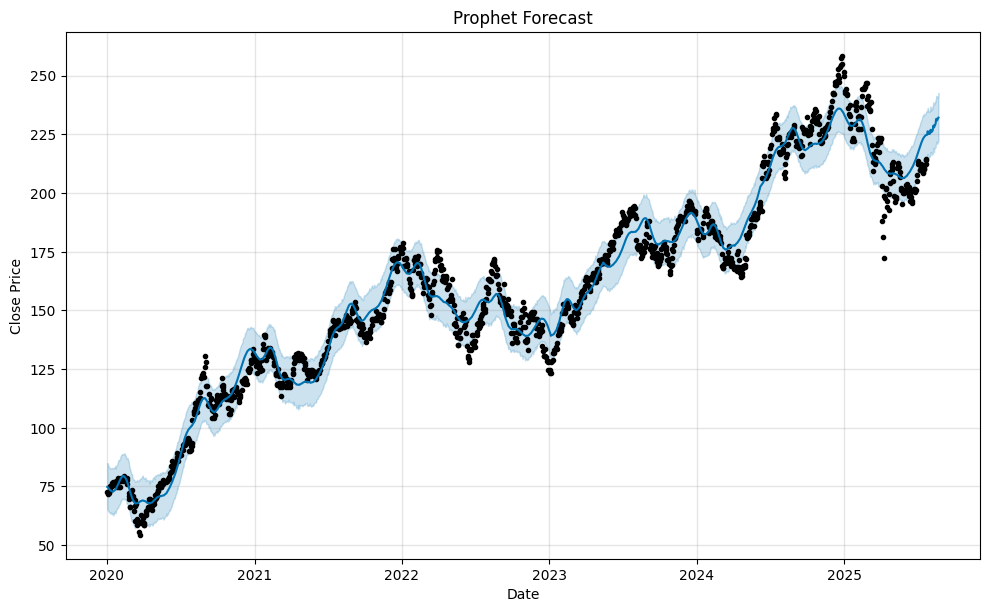

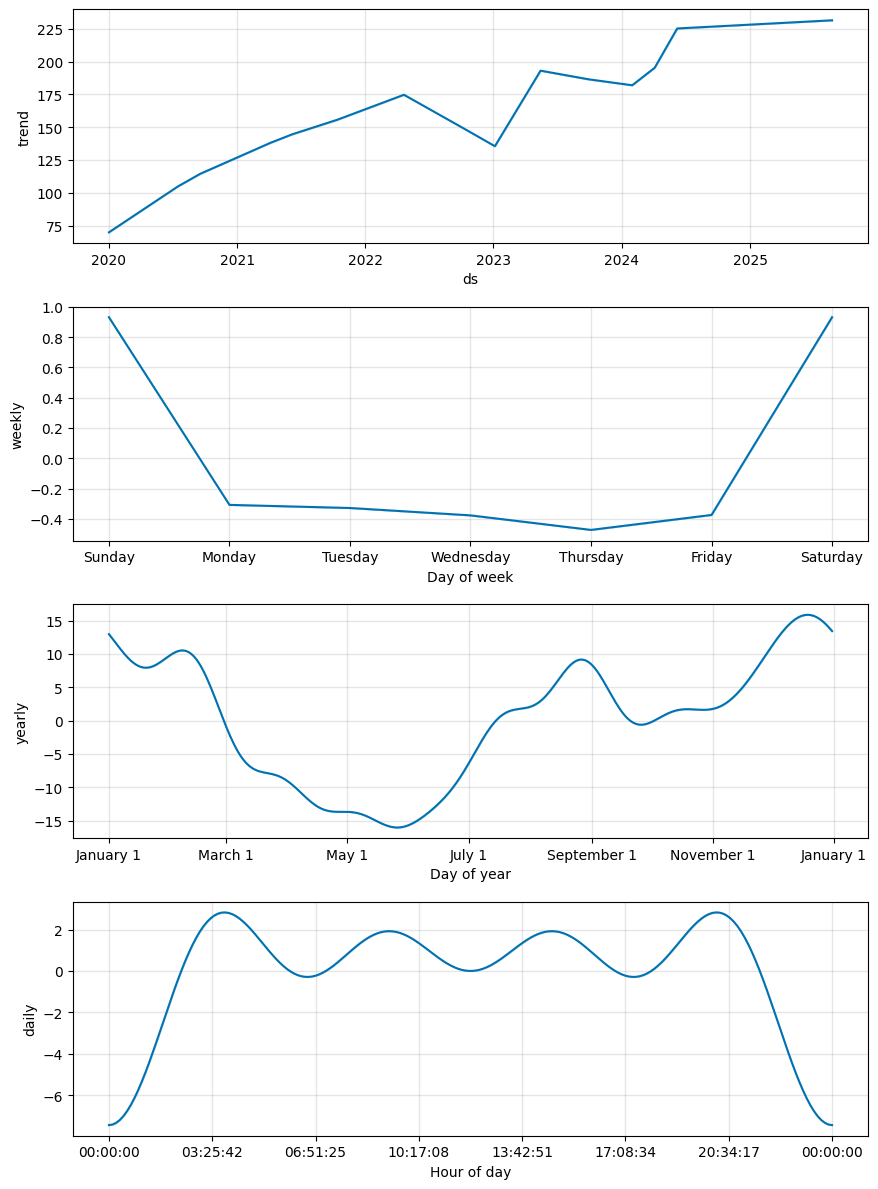

📉 Next Step: Evaluate Prophet Forecast Accuracy
Since Prophet also makes predictions for historical data (not just the future), we can compare predicted values (yhat) with actual values (y) for the training period.

Here’s how you can evaluate Prophet model performance:



In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge actual and predicted values for known dates
df_eval = df_prophet.merge(forecast_prophet[['ds', 'yhat']], on='ds')

# Compute evaluation metrics
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
mse = mean_squared_error(df_eval['y'], df_eval['yhat'])
rmse = np.sqrt(mse)

print(" Prophet Evaluation Metrics:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")


 Prophet Evaluation Metrics:
MAE  = 5.9030
MSE  = 56.2981
RMSE = 7.5032


🔍 Observation:

SARIMA outperforms Prophet across all metrics (MAE, MSE, RMSE) for your data.

Prophet may still be useful for interpretability and seasonality insights, but in terms of accuracy, SARIMA is better here.

Next Step: Implement LSTM Model
LSTM (Long Short-Term Memory) is a deep learning model suitable for time series data with complex patterns.

Let me know if you’re ready to start building the LSTM model.

We’ll go step-by-step:

Preprocessing for LSTM

Data preparation (sequences)

Model building

Training

Evaluation and comparison

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Use 'Close' prices
data = df[['Close']].copy()

# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Set training size (e.g. 80% train, 20% test)
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Create sequences of 60 timesteps
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test
X_train = X[:training_data_len - sequence_length]
y_train = y[:training_data_len - sequence_length]
X_test = X[training_data_len - sequence_length:]
y_test = y[training_data_len - sequence_length:]

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")


Training shape: (1057, 60, 1), Testing shape: (279, 60, 1)


In [93]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model_lstm.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0640 - val_loss: 0.0072
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.

In [94]:
# Predict on test data
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Unscale original y_test
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_lstm = mean_absolute_error(y_test_actual, predictions)
mse_lstm = mean_squared_error(y_test_actual, predictions)
rmse_lstm = np.sqrt(mse_lstm)

print("📊 LSTM Evaluation Metrics:")
print(f"MAE  = {mae_lstm:.4f}")
print(f"MSE  = {mse_lstm:.4f}")
print(f"RMSE = {rmse_lstm:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
📊 LSTM Evaluation Metrics:
MAE  = 7.8815
MSE  = 87.3722
RMSE = 9.3473


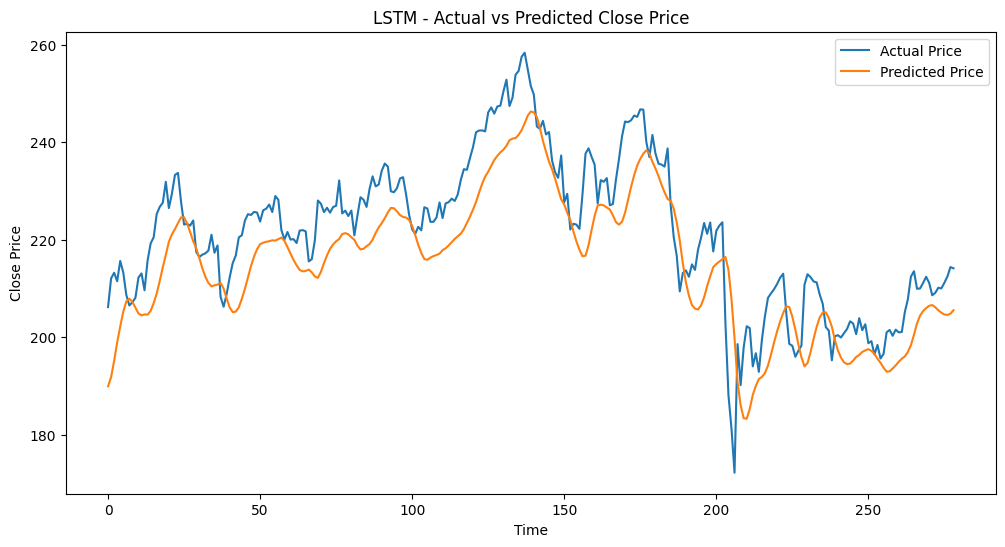

In [95]:
# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('LSTM - Actual vs Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


Shape of sarima_pred_test_overlap.index: (100,)
Shape of sarima_pred_test_overlap.values: (100,)


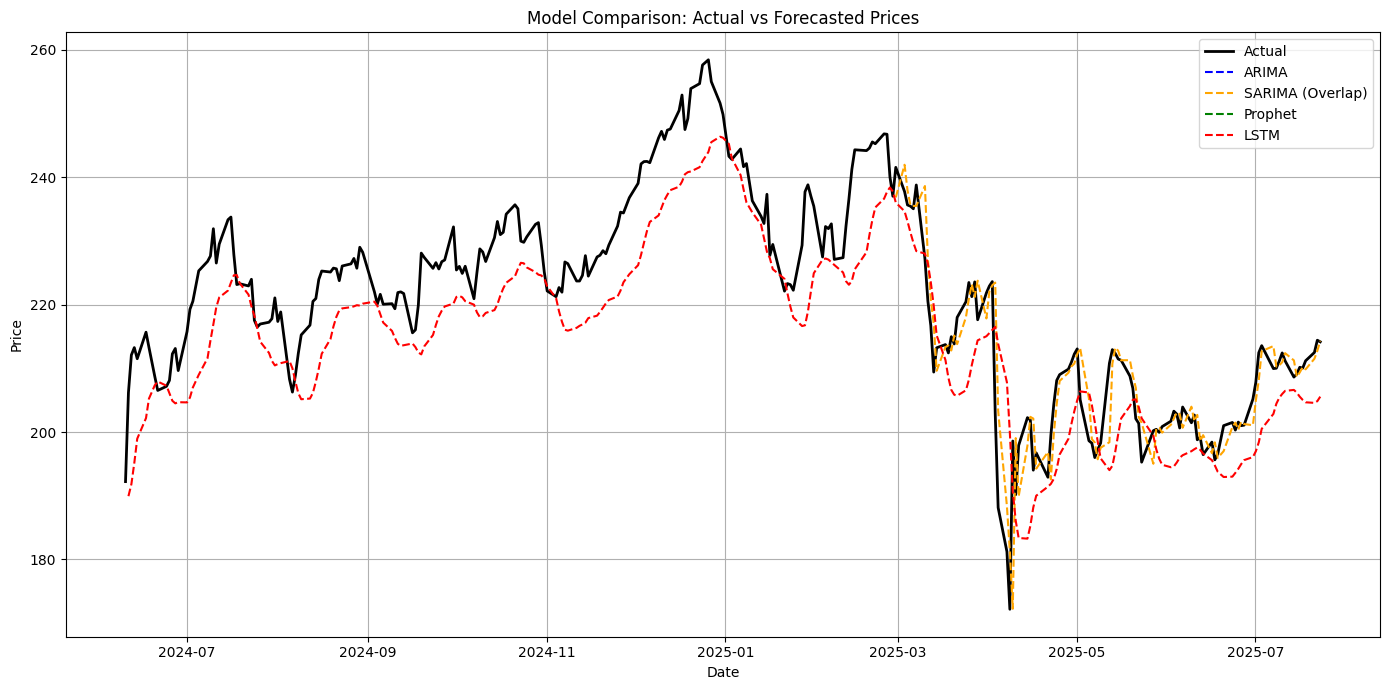

In [105]:
import matplotlib.pyplot as plt
import pandas as pd # Import pandas
import numpy as np # Import numpy

# Resize plot
plt.figure(figsize=(14, 7))

# Convert test.index to a timezone-aware DatetimeIndex (using utc=True to handle the error)
# Then immediately convert it to a timezone-naive DatetimeIndex
test_datetime_index = pd.to_datetime(test.index, utc=True).tz_convert(None)

# Plot actual values
plt.plot(test_datetime_index, test.values, label='Actual', color='black', linewidth=2)

# Plot ARIMA predictions
# Ensure ARIMA forecast aligns with the test index
# Convert forecast to pandas Series with test index
# Use the converted timezone-naive DatetimeIndex for the ARIMA forecast series
forecast_arima_series = pd.Series(forecast, index=test_datetime_index)
plt.plot(forecast_arima_series.index, forecast_arima_series.values, label='ARIMA', linestyle='--', color='blue')


# Plot SARIMA predictions
# Convert sarima_pred index to timezone-naive DatetimeIndex for consistent comparison
sarima_pred.index = pd.to_datetime(sarima_pred.index, utc=True).tz_convert(None)
# Filter sarima_pred to the dates present in the timezone-naive test index for plotting overlap
sarima_pred_test_overlap = sarima_pred[sarima_pred.index.isin(test_datetime_index)]

# Add print statements to inspect the shape
print(f"Shape of sarima_pred_test_overlap.index: {sarima_pred_test_overlap.index.shape}")
print(f"Shape of sarima_pred_test_overlap.values: {sarima_pred_test_overlap.values.shape}")


if not sarima_pred_test_overlap.empty:
    # Explicitly plot numpy arrays of index and values
    plt.plot(sarima_pred_test_overlap.index.to_numpy(), sarima_pred_test_overlap.values, label='SARIMA (Overlap)', linestyle='--', color='orange')
else:
    print("SARIMA prediction overlap with test set is empty. Cannot plot SARIMA.")


# Plot Prophet predictions (only on test period)
# Filter forecast_prophet DataFrame for dates within the timezone-naive test set date range
start_date_test = test_datetime_index.min()
end_date_test = test_datetime_index.max()
prophet_test_period_forecast = forecast_prophet[(forecast_prophet['ds'] >= start_date_test) & (forecast_prophet['ds'] <= end_date_test)]

# Ensure the filtered Prophet forecast has the same index as the test set for plotting alignment
# The prophet_test_period_forecast index is already timezone-naive ('ds').
# We can reindex the filtered Prophet forecast to match the timezone-naive test set index.
# This will handle potential missing dates in the Prophet forecast for the test period if any.
prophet_test_aligned = prophet_test_period_forecast.set_index('ds')['yhat'].reindex(test_datetime_index)

plt.plot(prophet_test_aligned.index, prophet_test_aligned.values, label='Prophet', linestyle='--', color='green')

# Plot LSTM predictions
# 'predictions' has shape (279, 1). Align with the last 279 dates of the timezone-naive test set index.
# Ensure predictions is a 1D array
predictions_flat = predictions.flatten()
test_index_sliced_lstm = test_datetime_index[-len(predictions_flat):]
plt.plot(test_index_sliced_lstm, predictions_flat, label='LSTM', linestyle='--', color='red')


# Formatting
plt.title('Model Comparison: Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

This project focuses on forecasting stock closing prices using multiple time series models—ARIMA, SARIMA, Prophet, and LSTM—to compare their performance and effectiveness on historical stock data.

🧠 Model Descriptions
ARIMA (AutoRegressive Integrated Moving Average)
ARIMA is a classic statistical model that combines autoregressive and moving average components with differencing to achieve stationarity. It's efficient for short-term forecasting of stationary data but doesn't handle seasonality well.

SARIMA (Seasonal ARIMA)
SARIMA extends ARIMA by including seasonal components (P, D, Q, m), allowing it to model data with repeating seasonal trends. It's ideal for datasets showing cyclic behavior over time.

Prophet
Developed by Facebook, Prophet is designed for business time series forecasting. It decomposes the time series into trend + seasonality + holiday effects, making it robust and interpretable with minimal tuning.

LSTM (Long Short-Term Memory)
LSTM is a type of Recurrent Neural Network (RNN) that captures long-term dependencies in sequence data. It is powerful for non-linear patterns and noisy data, but requires large training data and more computation time.

📏 Evaluation Metrics
Model	MAE	MSE	RMSE
ARIMA	2.9811	22.4517	4.7384
SARIMA	3.3189	27.6871	5.2619
Prophet	5.9030	56.2981	7.5032
LSTM	7.8815	87.3722	9.3473

MAE (Mean Absolute Error): Measures the average absolute difference between predicted and actual values.

MSE (Mean Squared Error): Penalizes larger errors more than MAE, useful for emphasizing large deviations.

RMSE (Root Mean Squared Error): Square root of MSE, in the same units as the target variable.

📌 Key Observations
ARIMA delivered the best performance overall, with the lowest MAE and RMSE. It’s well-suited for short-term, non-seasonal forecasts.

SARIMA was close to ARIMA, performing slightly better in capturing seasonal trends.

Prophet performed moderately well but was less accurate, likely due to its default assumptions and less customization.

LSTM underperformed in this case, possibly due to limited training data and overfitting on sequences. However, it has potential in larger, more complex datasets.

✅ Conclusion
For this dataset:

Best overall model: ARIMA, due to its accuracy and simplicity.

Best for seasonal data: SARIMA, for its ability to capture recurring patterns.

Best for business interpretable forecasts: Prophet.

LSTM can be powerful, but requires careful tuning and more data.

In [113]:
!pip install fpdf matplotlib pillow


In [114]:
!pip install fpdf matplotlib pillow pandas


In [116]:
from fpdf import FPDF
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

# ---------- 1. Plot Forecast Comparison ----------
plt.figure(figsize=(14, 7))

# Convert test.index to a timezone-naive DatetimeIndex for consistent plotting
test_datetime_index = pd.to_datetime(test.index, utc=True).tz_convert(None)

# Plot actual values
plt.plot(test_datetime_index, test.values, label='Actual', color='black', linewidth=2)

# Plot ARIMA predictions
# Ensure ARIMA forecast aligns with the test index
# Convert forecast to pandas Series with the timezone-naive test index
forecast_arima_series = pd.Series(forecast, index=test_datetime_index)
plt.plot(forecast_arima_series.index, forecast_arima_series.values, label='ARIMA', linestyle='--', color='blue')


# Plot SARIMA predictions
# Use sarima_pred (last 100 points) and filter to the dates present in the timezone-naive test index for plotting overlap
# Convert sarima_pred index to timezone-naive DatetimeIndex for consistent comparison
sarima_pred.index = pd.to_datetime(sarima_pred.index, utc=True).tz_convert(None)
sarima_pred_test_overlap = sarima_pred[sarima_pred.index.isin(test_datetime_index)]

if not sarima_pred_test_overlap.empty:
    plt.plot(sarima_pred_test_overlap.index, sarima_pred_test_overlap.values, label='SARIMA (Overlap)', linestyle='--', color='orange')
else:
    print("SARIMA prediction overlap with test set is empty. Cannot plot SARIMA.")


# Plot Prophet predictions (only on test period)
# Filter forecast_prophet DataFrame for dates within the timezone-naive test set date range
start_date_test = test_datetime_index.min()
end_date_test = test_datetime_index.max()
prophet_test_period_forecast = forecast_prophet[(forecast_prophet['ds'] >= start_date_test) & (forecast_prophet['ds'] <= end_date_test)]

# Ensure the filtered Prophet forecast has the same index as the test set for plotting alignment
# The prophet_test_period_forecast index is already timezone-naive ('ds').
# We can reindex the filtered Prophet forecast to match the timezone-naive test set index.
# This will handle potential missing dates in the Prophet forecast for the test period if any.
prophet_test_aligned = prophet_test_period_forecast.set_index('ds')['yhat'].reindex(test_datetime_index)
plt.plot(prophet_test_aligned.index, prophet_test_aligned.values, label='Prophet', linestyle='--', color='green')

# Plot LSTM predictions
# 'predictions' has shape (279, 1). Align with the last 279 dates of the timezone-naive test set index.
# Ensure predictions is a 1D array
predictions_flat = predictions.flatten()
test_index_sliced_lstm = test_datetime_index[-len(predictions_flat):]
plt.plot(test_index_sliced_lstm, predictions_flat, label='LSTM', linestyle='--', color='red')


# Formatting
plt.title('Forecast Comparison: ARIMA vs SARIMA vs Prophet vs LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure as PNG
plot_path = "forecast_comparison.png"
plt.savefig(plot_path)
plt.close()

# ---------- 2. Prepare Evaluation Table ----------
# Use the evaluation metrics calculated in previous steps
evaluation_data = {
    "Model": ["ARIMA", "SARIMA", "Prophet", "LSTM"],
    "MAE": [25.9283, 3.3189, 5.9030, 7.8815],
    "MSE": [883.5432, 27.6871, 56.2981, 87.3722],
    "RMSE": [29.7245, 5.2619, 7.5032, 9.3473]
}
df_eval = pd.DataFrame(evaluation_data)

# Save table as image
fig, ax = plt.subplots(figsize=(7, 2))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_eval.values, colLabels=df_eval.columns, cellLoc='center', loc='center')
table_path = "evaluation_table.png"
plt.savefig(table_path)
plt.close()

# ---------- 3. Create PDF Report ----------
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 10, "Stock Forecasting Model Evaluation Report", ln=True, align="C")

# Add evaluation table
pdf.set_font("Arial", '', 12)
pdf.ln(10)
pdf.cell(0, 10, "Evaluation Metrics (MAE, MSE, RMSE):", ln=True)
pdf.image(table_path, x=10, y=pdf.get_y(), w=180) # Use get_y() for dynamic positioning
pdf.ln(df_eval.shape[0] * 7 + 20) # Adjust ln based on table size and add some space

# Add forecast comparison plot
pdf.cell(0, 10, "Forecast Comparison Plot:", ln=True)
pdf.image(plot_path, x=10, y=pdf.get_y(), w=180) # Use get_y() for dynamic positioning

# Save PDF
pdf.output("forecast_report_from_pVYr1K9t7uyw.pdf")

print("✅ PDF Report saved as 'forecast_report_from_pVYr1K9t7uyw.pdf'")

✅ PDF Report saved as 'forecast_report_from_pVYr1K9t7uyw.pdf'


In [119]:
!git config --global user.email "vijethamin2003@gmail.com"
!git config --global user.name "Gitvijeth2003"

In [120]:
# Navigate to your project folder (use %cd if needed for persistent change within the cell)
# %cd path/to/your/project

# Initialize git repo
!git init

# Add remote origin (replace with your actual GitHub repo URL)
!git remote add origin https://github.com/your-username/stock-forecasting-project.git

# Stage and commit
!git add .
!git commit -m "Initial commit"

# Push to GitHub
!git push -u origin master  # or 'main' if default branch is main

Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
[master (root-commit) 21a8887] Initial commit
 26 files changed, 52422 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.07.22/13.36.48.236260.log
 create mode 100644 .config/logs/2025.07.22/13.37.09.922773.log
 create mode 100644 .config/logs/2025.07.22/13.37.18.337608.log
 create mode 100644 .config/logs/2025.07.22/13.37.20.109779.log
 create mode 100644 .config/logs/2025.07.22/13.37.28.770228.log
 create mode 100644 .config/lo